In [1]:
import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Build transportation grah
G = nx.DiGraph()

# Add nodes
G.add_node(0, supply=7)
G.add_node(1, supply=11)
G.add_node(2, supply=18)
G.add_node(3, supply=12)
G.add_node(4, supply=-10)
G.add_node(5, supply=-23)
G.add_node(6, supply=-15)

# Add edges
capacity = 20
G.add_edge(0, 4, weight=5, capacity=capacity)
G.add_edge(0, 5, weight=6, capacity=capacity)
G.add_edge(1, 4, weight=8, capacity=capacity)
G.add_edge(1, 5, weight=4, capacity=capacity)
G.add_edge(1, 6, weight=3, capacity=capacity)
G.add_edge(2, 5, weight=5, capacity=capacity)
G.add_edge(3, 5, weight=3, capacity=capacity)
G.add_edge(3, 6, weight=6, capacity=capacity)

In [3]:
# Note minus sign for convention
# In our formulation:
# -> 1 means arc exits node
# -> -1 means arc enters node
A = -nx.linalg.graphmatrix.incidence_matrix(G, oriented=True)
print("A =\n", A.todense())

A =
 [[ 1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.]
 [-1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0. -1.  0. -1. -1.  0.]
 [ 0.  0.  0.  0. -1.  0.  0. -1.]]


In [4]:
# Get weights, capacities, and supply vectors
c = np.array([G[u][v]['weight'] for u,v in G.edges])
u = np.array([G[u][v]['capacity'] for u,v in G.edges])
b = np.array([G.nodes[u]['supply'] for u in G.nodes])

In [5]:
# SCIPY (HIGHS) runs a simple method, which, as you know, returns exactly integral 
# solutions at vertices. Other solvers such as CLARABEL use interior-point methods 
# and they return slightly imprecise solutions that are not exactly integral.
x = cp.Variable(len(G.edges))
objective = cp.Minimize(c @ x)
constraints = [A @ x == b, 0 <= x, x <= u]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCIPY)
print("Optimal cost =", problem.objective.value)

Optimal cost = 230.0


In [6]:
# Show solution
# Note: x is integral!
print("x = ", x.value)

x =  [ 7. -0.  3. -0.  8. 18.  5.  7.]


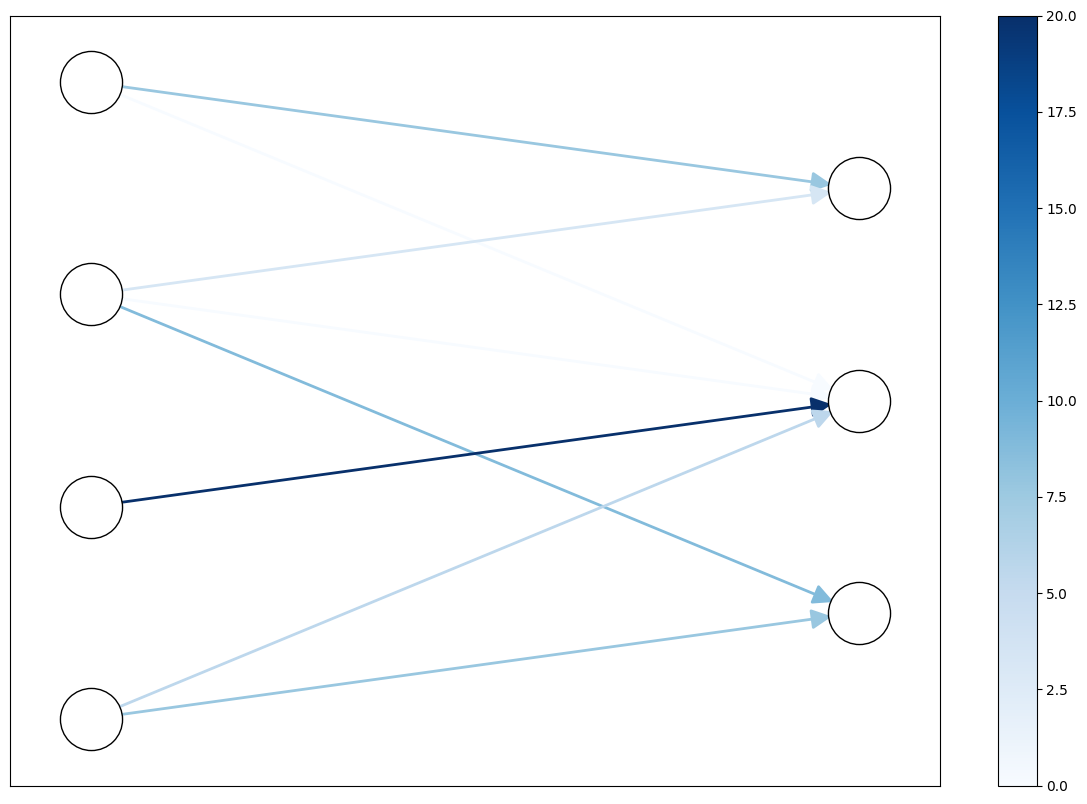

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = plt.cm.Blues

# Positions in 2d plot
layout = {0: np.array([0.0, 4.0]),
          1: np.array([0.0, 3.0]),
          2: np.array([0.0, 2.0]),
          3: np.array([0.0, 1.0]),
          4: np.array([1.0, 3.5]),
          5: np.array([1.0, 2.5]),
          6: np.array([1.0, 1.5]),
         }
nx.draw_networkx_nodes(G, layout, node_color='w', edgecolors='k', node_size=2000)
nx.draw_networkx_edges(G, layout, edge_cmap=cmap, edge_color=x.value, 
                       width=2, arrowsize=30, min_target_margin=20)

# Print colormap
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=capacity)
                          )
cbar = plt.colorbar(sm, ax=plt.gca())

plt.show()